### Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.metrics import recall_score, f1_score

import tensorflow as tf
from keras import Sequential, regularizers
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras_tuner import HyperModel, Hyperband

print("TensorFlow version: ", tf.__version__)
print("Number of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version:  2.19.0
Number of GPUs available:  1


In [3]:
!nvidia-smi
# !kill -9 <PID>

Wed Apr  2 22:07:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:25:00.0 Off |                    0 |
| N/A   50C    P0             66W /  250W |   17957MiB /  40960MiB |     22%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Data Preprocessing

In [4]:
spike = 2
wind_cols = ['uSq','Z2','Z4']
scaled_wind_cols = ['scaled_' + col for col in wind_cols]

# Load datasets
df1 = pd.read_csv('Data_2004_2013.csv')
df1['Spike'] = (df1['H'] > spike).astype(int)

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)

# Train-Test split
# df_train: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2008-11-01 00:00:00 ~ 2013-10-31 23:00:00]
# df_test: [2007-11-01 00:00:00 ~ 2008-10-31 23:00:00]
split1 = pd.to_datetime('2007-10-31 23:59:00')
split2 = pd.to_datetime('2008-10-31 23:59:00')
df_train = df1[(df1.index < split1) | (df1.index > split2)]
df_test = df1[(df1.index > split1) & (df1.index < split2)]

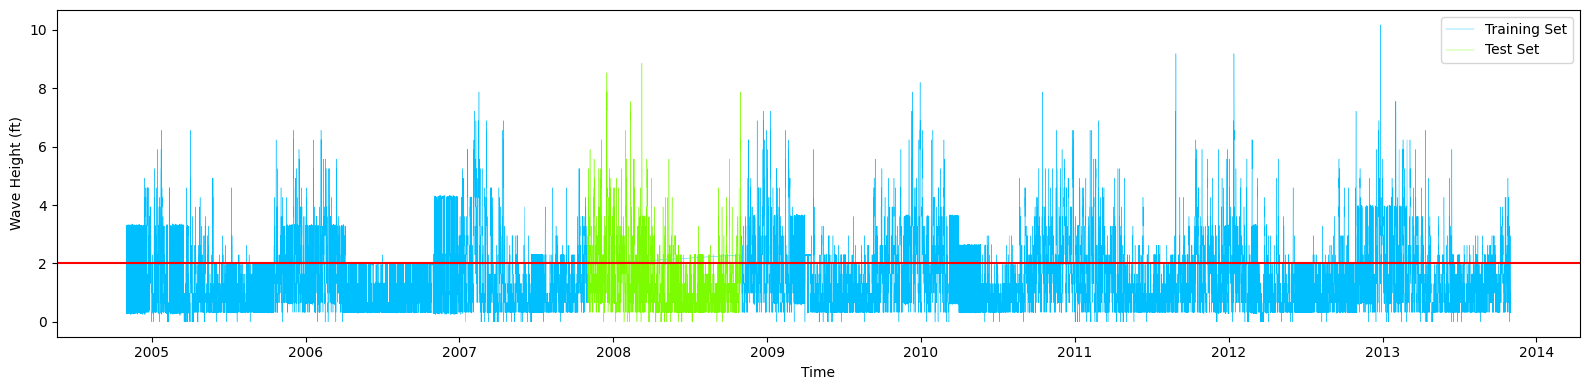

In [5]:
plt.figure(figsize=(16, 4))
plt.plot(df_train['H'], linewidth=0.3, color='deepskyblue', label='Training Set')
plt.plot(df_test['H'], linewidth=0.3, color='lawngreen', label='Test Set')
plt.axhline(y=spike, color='r')

plt.xlabel('Time')
plt.ylabel('Wave Height (ft)')
plt.legend()

plt.tight_layout()
plt.show()

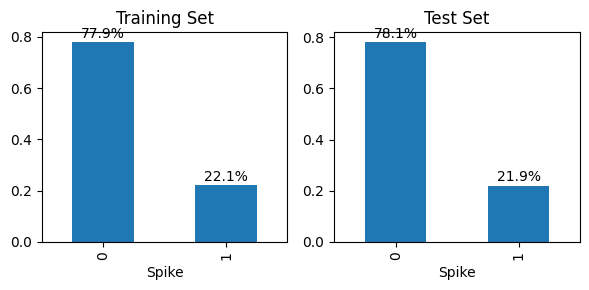

In [6]:
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
train_counts = df_train['Spike'].value_counts(normalize=True)
train_counts.plot(kind='bar')
plt.title('Training Set')
for i, v in enumerate(train_counts):
    plt.text(i, v+0.005, f'{v:.1%}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
test_counts = df_test['Spike'].value_counts(normalize=True)
test_counts.plot(kind='bar')
plt.title('Test Set')
for i, v in enumerate(test_counts):
    plt.text(i, v+0.005, f'{v:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Data Preparation: Train-Test-Validation Split

In [7]:
time_step = 6
features = ['Spike'] + scaled_wind_cols

def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step+1), 1:]) # (Past + Current) hours wind features
        y.append(data[i+time_step, 0])        # Current hour wave height
    return np.array(X), np.array(y)

# Training set: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2009-11-01 00:00:00 ~ 2013-10-31 23:00:00]
# Validation set: [2008-11-01 00:00:00 ~ 2009-10-31 23:00:00]
split3 = pd.to_datetime('2009-10-31 23:59:00')
df_train1 = df_train[df_train.index < split1]
df_train2 = df_train[df_train.index > split3]
df_val = df_train[(df_train.index > split2) & (df_train.index < split3)]

X_train1, y_train1 = create_sequences(df_train1[features].values, time_step)
X_train2, y_train2 = create_sequences(df_train2[features].values, time_step)
X_train, y_train = np.concatenate((X_train1, X_train2), axis=0), np.concatenate((y_train1, y_train2), axis=0)
X_val, y_val = create_sequences(df_val[features].values, time_step)
X_test, y_test = create_sequences(df_test[features].values, time_step)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(61332, 7, 3)
(8754, 7, 3)
(8778, 7, 3)


### Model Selection and Implementation

In [ ]:
epochs = 50
batch_size = 64
model_file = 'model_2.keras'

# Model architecture
def create_model(X_train):
    model = Sequential([
        # Input layer with shape: (samples, time_steps, features)
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        
        # LSTM layers
        LSTM(64, activation='tanh', kernel_regularizer=regularizers.l2(0.01), dropout=0.2, return_sequences=True),
        LSTM(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01), dropout=0.2, return_sequences=False),
        
        # Output layer
        Dense(1, activation='sigmoid'),
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])
    
    return model

# Class weights computation
w_array = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
w_dict = {i:w_array[i] for i in range(len(w_array))}

# Train and save the model (architecture + weights)
model = create_model(X_train)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es], class_weight=w_dict)
model.save(model_file)

# Plot the training & validation loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Hyperparameters Tuning

- **Time steps**: 6, 12, 24
- **Batch size**: 32, 64, 128
- **# of LSTM layers**: 1, 2
- **# of LSTM units**: 16, 32, 64, 128
- **Dropout rate**: 0.2
- **Activation**: 'tanh' (might work better for LSTM layers)
- **Learning rate**: logarithmic sampling of $10^{-4}$ ~ $10^{-2}$

In [8]:
epochs = 50
batch_size = 64

class LSTMHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        
        # Input layer with shape: (samples, time_steps, features)
        model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
        
        # Tunable LSTM layers and units
        num_layers = hp.Int('layers', min_value=1, max_value=2, step=1)
        for i in range(num_layers):
            model.add(LSTM(
                hp.Choice(f'units_{i}', values=[16, 32, 64, 128]),
                activation = hp.Choice(f'activation_{i}', values=['tanh']),
                kernel_regularizer = regularizers.l2(0.01),
                dropout = hp.Choice(f'dropout_{i}', values=[0.2]),
                return_sequences = True if i < num_layers-1 else False))
        
        # Output layer
        model.add(Dense(1, activation='sigmoid'))
        
        # Compile the model
        model.compile(
            optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
            loss = 'binary_crossentropy',
            metrics = ['AUC'],
        )
        
        return model

# Search space setup
tuner = Hyperband(
    LSTMHyperModel(),
    objective = 'val_loss',
    max_epochs = 30,
    factor = 3,
    directory = 'hp_tuning',
    project_name = 'model_2',
)

# Class weights computation
w_array = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
w_dict = {i:w_array[i] for i in range(len(w_array))}

# Hyperparameter tuning
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tuner.search(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es], class_weight=w_dict)

Reloading Tuner from hp_tuning/model_2/tuner0.json


In [9]:
# Best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)
print()

# Best model
best_model = tuner.hypermodel.build(best_hp)
best_model.compile(optimizer=Adam(learning_rate=best_hp.values['learning_rate']), loss='binary_crossentropy', metrics=['AUC'])
print(best_model.summary())

{'layers': 1, 'units_0': 64, 'activation_0': 'tanh', 'dropout_0': 0.2, 'learning_rate': 0.0011690148784953402, 'units_1': 32, 'activation_1': 'tanh', 'dropout_1': 0.2, 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0046'}



I0000 00:00:1743646090.495052 2895486 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38483 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

None


I0000 00:00:1743646098.383200 2895978 cuda_dnn.cc:529] Loaded cuDNN version 90300


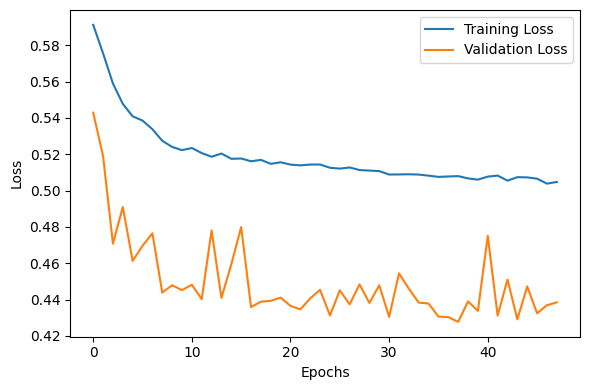

In [10]:
model_file = 'best_model_2.keras'

# Train and save the model (architecture + weights)
history = best_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es], class_weight=w_dict, verbose=0)
best_model.save(model_file)

# Plot the training & validation loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation

In [11]:
threshold = 0.3

# Load the saved model
model = load_model(model_file)

# Training error
y_pred1 = model.predict(X_train, verbose=0)
y_pred1_raw = (y_pred1 >= threshold).astype(int)
y_true1 = pd.concat([df_train1['Spike'][time_step:], df_train2['Spike'][time_step:]], axis=0)

# Validation error
y_pred2 = model.predict(X_val, verbose=0)
y_pred2_raw = (y_pred2 >= threshold).astype(int)
y_true2 = df_val['Spike'][time_step:]

# Test error
y_pred3 = model.predict(X_test, verbose=0)
y_pred3_raw = (y_pred3 >= threshold).astype(int)
y_true3 = df_test['Spike'][time_step:]

print(f'Training Recall: {recall_score(y_true1, y_pred1_raw):.3f}')
print(f'Validation Recall: {recall_score(y_true2, y_pred2_raw):.3f}')
print(f'Test Recall: {recall_score(y_true3, y_pred3_raw):.3f}')
print()
print(f'Training F1: {f1_score(y_true1, y_pred1_raw):.3f}')
print(f'Validation F1: {f1_score(y_true2, y_pred2_raw):.3f}')
print(f'Test F1: {f1_score(y_true3, y_pred3_raw):.3f}')

Training Recall: 0.822
Validation Recall: 0.791
Test Recall: 0.838

Training F1: 0.567
Validation F1: 0.617
Test F1: 0.593


### Model Output

In [12]:
# Create sequences for the full dataset
X, _ = create_sequences(df1[features].values, time_step)

# Add predicted spikes
df1['Spike_pred'] = 0.0
df1.loc[df1.index[time_step:], 'Spike_pred'] = model.predict(X, verbose=0).flatten()
df1.to_csv('Data_2004_2013.csv')

df1.head(10)

,H,uSq,Z2,Z4,scaled_H,scaled_uSq,scaled_Z2,scaled_Z4,H_pred,Spike,Spike_pred
TimeStamp_1,,,,,,,,,,,
2004-11-01 00:00:00,3.249133,19.225945,556.247086,465615.964363,0.319463,0.042443,0.101141,0.021635,0.000000,1,0.000000
2004-11-01 01:00:00,3.249133,47.299731,872.475497,296853.635864,0.319463,0.111609,0.181946,0.012009,0.000000,1,0.000000
2004-11-01 02:00:00,1.960359,43.096993,832.812792,310991.288972,0.192748,0.101255,0.171811,0.012816,0.000000,0,0.000000
2004-11-01 03:00:00,2.001249,28.241040,674.161969,384177.000917,0.196768,0.064654,0.131272,0.016990,0.000000,1,0.000000
2004-11-01 04:00:00,3.254957,35.278017,753.487381,343731.733585,0.320036,0.081991,0.151541,0.014683,0.000000,1,0.000000
2004-11-01 05:00:00,3.298333,33.337921,732.475598,353592.016416,0.324301,0.077211,0.146172,0.015245,0.000000,1,0.000000
2004-11-01 06:00:00,0.298153,67.513173,1042.361020,248471.996288,0.029315,0.161410,0.225356,0.009250,0.155313,0,0.416251
2004-11-01 07:00:00,0.329992,43.711596,838.730115,308797.214744,0.032446,0.102769,0.173323,0.012690,0.166292,0,0.517614
2004-11-01 08:00:00,0.307853,55.203975,942.560154,274780.895794,0.030269,0.131084,0.199855,0.010750,0.170200,0,0.516793
